FID SCORE: 2.02


*   Sucheta- Building the generator, discriminator
*   Sucheta- Wasserstein Loss for the critic, clipping weights
*   Ayesha- Optimizer, combining and compiling the model
*   Ayesha- Training Wgan
*   Ayesha- FID Score







In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading images from file
images = np.load('/content/drive/My Drive/images.npy')

# Loading labels from file
labels = np.load('/content/drive/My Drive/labels.npy')

print(f"Images loaded: {images.shape}")
print(f"Labels loaded: {labels.shape}")

Images loaded: (8390, 224, 224, 3)
Labels loaded: (8390,)


In [ ]:
labels_unique = np.unique(labels)
print(f"Unique labels: {labels_unique}")

Unique labels: ['drink' 'food' 'inside' 'menu' 'outside']


Total images for class 'menu': (1678, 224, 224, 3)


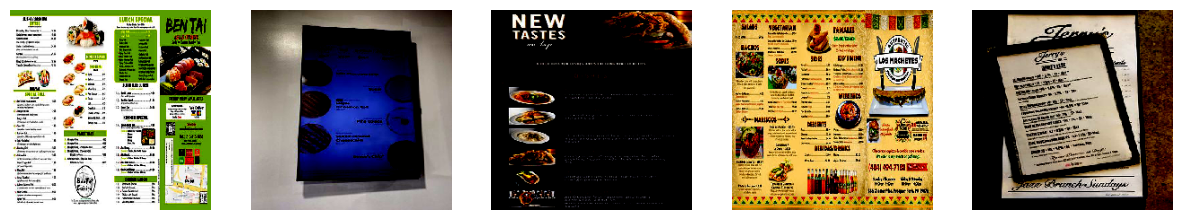

In [ ]:
# Separate images by class
selected_class = 'menu'
class_indices = np.where(labels == selected_class)[0]
class_images = images[class_indices]

print(f"Total images for class '{selected_class}': {class_images.shape}")

# Plot the images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(class_images[i, :, :, :])  # Display RGB images
    axs[i].axis('off')
plt.show()

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def build_generator():
    model = Sequential()
    model.add(Dense(512 * 14 * 14, activation="relu", input_dim=100))
    model.add(Reshape((14, 14, 512)))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())  # BatchNormalization
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())  # BatchNormalization
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())  # BatchNormalization
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, activation="tanh", padding="same"))
    return model


In [ ]:
def build_critic():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=(224, 224, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))  # No activation function for unbounded output
    return model

In [ ]:
# Normalize images to [-1, 1]
class_images = class_images / 127.5 - 1  # Assuming images are in the range [0, 255]


In [ ]:
# Wasserstein Loss for the critic
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [ ]:
# Build the generator and critic models
generator = build_generator()
critic = build_critic()

In [ ]:
# Function for clipping critic weights
def clip_weights(critic, clip_value=0.01):
    for layer in critic.layers:
        if hasattr(layer, 'kernel'):
            K.set_value(layer.kernel, K.clip(layer.kernel, -clip_value, clip_value))

In [ ]:
# Generator Output Check
def generate_and_plot_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))  # Generate random noise for the generator
    generated_images = generator.predict(noise)  # Generate images from noise

    # Debugging: Print out the shapes of the generated images
    print(f"Generated image shape: {generated_images.shape}")

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axs[i].imshow(generated_images[i])  # Display the generated images
        axs[i].axis('off')
    plt.show()